# RNN model for Earthquake project

In this notebook, in order to build an efficient model to predict earthquakes, i'll follow these steps :  

- Load data, create train/test datasets
- Preprocess the data (thanks to EDA)
- Define a model : Recurrent neural network (RNN)
- Evaluate the model
- Tune the model


## Load data and split

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load all the data
float_data = pd.read_csv(r'C:\Users\alexi\Documents\LANL-Earthquake-Prediction\train.csv',
                    dtype={'acoustic_data': np.int16,
                           'time_to_failure': np.float32}).values

In [3]:
# Create a list with earthquakes indices
earthquakes = []
for i in range(float_data.shape[0]-1):
    if (float_data[i+1,1]-float_data[i,1] > 1):
        earthquakes.append(i)

In [4]:
earthquakes

[5656573,
 50085877,
 104677355,
 138772452,
 187641819,
 218652629,
 245829584,
 307838916,
 338276286,
 375377847,
 419368879,
 461811622,
 495800224,
 528777114,
 585568143,
 621985672]

In [49]:
# In order to manage my low computational resources, i will do the model engineering on a small subset. 
train_data = float_data[earthquakes[1]+1:earthquakes[2],:]
valid_data = float_data[earthquakes[2]+1:earthquakes[2]+2000000,:]

## Preprocessing

From informations given by our EDA, we have to :
- generate batches (sized (n_steps * step_length)) 
- apply standardization
- extract statistical features

The idea of the statistical features is to make the RNN job a bit easier.

In [7]:
# Creates different statistical features from a value
def extract_features(z):
     return np.c_[z.mean(axis=1), 
                  z.max(axis=1),
                  z.std(axis=1),
                  z.var(axis=1),
                  np.quantile(z,0.05,axis=1),
                  np.quantile(z,0.95,axis=1)]

In [54]:
# Preprocesses a subset
def preprocess(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1)-5)/10

    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 50:])]

In [55]:
n_features = preprocess(float_data[0:150000]).shape[1]

In [56]:
# Generates batches ready for LSTM model 
def generator(data, batch_size=4, n_steps=150, step_length=1000):
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(n_steps * step_length, (len(data) - 1), size=batch_size)
         
        # Initialize feature matrices and targets
        inputs = np.zeros((batch_size, n_steps, n_features))
        outputs = np.zeros(batch_size, )
        
        for col, row in enumerate(rows):
            inputs[col] = preprocess(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            ouputs[col] = data[row - 1, 1]
        yield inputs, outputs

## Define Model : LSTM

<b>Principle :</b> RNN is like a wrap feedforward NN. Some signals are going back in the NN, so it keeps information about previous time steps to understand the current state. 

RNN is usefull with cases of strong local correlation in time, but not global.

<b>LSTM</b> cell (Long Short Time Memory) has the advantage to delete backpropagation signals to avoid too long dependency between signals.

In [16]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM, Dropout,Bidirectional,TimeDistributed
from keras.optimizers import adam

In [80]:
# Train the model and return loss values
def fit_lstm(train, test, nb_epoch, neurons):
    
    global model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(None, n_features)))
    model.add(Dense(10))
    model.add(Dense(1))

    model.summary()
    model.compile(optimizer=adam(lr=0.0005), loss="mae")
    
    history = model.fit_generator(train_gen,
                              steps_per_epoch=150,
                              epochs=nb_epoch,
                              verbose=2,
                              validation_data=valid_gen,
                              validation_steps=10)
    
    return history

## Model evaluation

Evaluation Metric : Mean Absolute Error



In [58]:
# Plot loss and val_loss over epochs
def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return plt

In [83]:
# Run and evaluate the model

def run():

    # config
    n_batch = 4
    n_epochs = 100
    n_neurons = 6
        
    global train_gen, valid_gen
    train_gen = generator(train_data, batch_size=n_batch)
    valid_gen = generator(test_data, batch_size=n_batch)

    history = fit_lstm(train_gen, valid_gen, n_epochs, n_neurons)
    perf_plot(history, what = 'loss')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_96 (LSTM)               (None, 6)                 456       
_________________________________________________________________
dense_181 (Dense)            (None, 10)                70        
_________________________________________________________________
dense_182 (Dense)            (None, 1)                 11        
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 - 82s - loss: 5.9936 - val_loss: 9.5715
Epoch 2/100
 - 34s - loss: 4.1578 - val_loss: 7.2742
Epoch 3/100
 - 34s - loss: 3.6222 - val_loss: 6.1331
Epoch 4/100
 - 34s - loss: 3.5800 - val_loss: 5.6389
Epoch 5/100
 - 35s - loss: 3.7198 - val_loss: 4.8632
Epoch 6/100
 - 28s - loss: 3.5466 - val_loss: 5.0974
Epoch 7/100
 - 32s - loss: 3.4021 - val_loss: 5.5733
Epoch 8/100
 - 38s - loss: 3.3527 - v

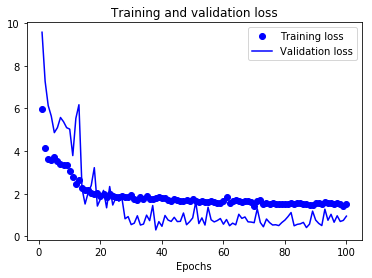

In [84]:
run()

## Tune model

Hyperparameters to tune in LSTM model:

- <b>Number of Epochs :</b> how many times the dataset is entirely used for training.
- <b>Batch Size :</b>  number of samples that will be propagated through the network.
- <b>Number of Neurons :</b> how many neurons are in the LSTM layer.

The methodology i use consists in holding simple batch size and number of neurons while tuning the number of epochs first. Then I tune the batch size, and finally the number of neurons. 

Then, if we observe some issues like overfitting, it's still possible to add layers like dropout.

In [68]:
# For some hyperparameters defined : train and evaluate the model several times. 
def experiment(batch_size, neurons, epochs):
    
    repeats = 3
    error_scores = list()
    train_gen = generator(train_data, batch_size=batch_size)
    valid_gen = generator(valid_data, batch_size=batch_size)
    
    for r in range(repeats):
        history = fit_lstm(train_gen, valid_gen, epochs, neurons)
        loss = history.history['loss'][-1]
        error_scores.append(loss)
        
    return error_scores

### Tune the number of epochs

First we will explore the effect of varying the number of epochs.<br>
For the first experiments, we hold <b>batch_size = 4</b> and we use a <b>single neuron</b>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 1)                 56        
_________________________________________________________________
dense_101 (Dense)            (None, 10)                20        
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 11        
Total params: 87
Trainable params: 87
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 36s - loss: 6.5000 - val_loss: 11.1958
Epoch 2/10
 - 25s - loss: 5.2612 - val_loss: 9.8500
Epoch 3/10
 - 27s - loss: 4.5251 - val_loss: 8.4883
Epoch 4/10
 - 28s - loss: 3.9574 - val_loss: 7.3948
Epoch 5/10
 - 20s - loss: 3.6945 - val_loss: 6.7720
Epoch 6/10
 - 19s - loss: 3.6340 - val_loss: 6.2552
Epoch 7/10
 - 19s - loss: 3.5908 - val_loss: 5.9173
Epoch 8/10
 - 19s - loss: 3.5591 - val_loss: 

 - 18s - loss: 3.4714 - val_loss: 5.5895
Epoch 9/50
 - 18s - loss: 3.4262 - val_loss: 5.4317
Epoch 10/50
 - 18s - loss: 3.4347 - val_loss: 5.3633
Epoch 11/50
 - 18s - loss: 3.5700 - val_loss: 5.6858
Epoch 12/50
 - 18s - loss: 3.5515 - val_loss: 5.5341
Epoch 13/50
 - 18s - loss: 3.4418 - val_loss: 5.3614
Epoch 14/50
 - 18s - loss: 3.4807 - val_loss: 5.2780
Epoch 15/50
 - 18s - loss: 3.4502 - val_loss: 5.4749
Epoch 16/50
 - 19s - loss: 3.5621 - val_loss: 5.4659
Epoch 17/50
 - 19s - loss: 3.5708 - val_loss: 5.5617
Epoch 18/50
 - 18s - loss: 3.5765 - val_loss: 5.5480
Epoch 19/50
 - 18s - loss: 3.5818 - val_loss: 5.4767
Epoch 20/50
 - 18s - loss: 3.6740 - val_loss: 5.2370
Epoch 21/50
 - 18s - loss: 3.5114 - val_loss: 5.3190
Epoch 22/50
 - 18s - loss: 3.6460 - val_loss: 5.3792
Epoch 23/50
 - 18s - loss: 3.6374 - val_loss: 5.3777
Epoch 24/50
 - 18s - loss: 3.6328 - val_loss: 5.4924
Epoch 25/50
 - 18s - loss: 3.5052 - val_loss: 5.2932
Epoch 26/50
 - 18s - loss: 3.5466 - val_loss: 5.2726
Epoch 

 - 18s - loss: 3.4828 - val_loss: 5.4236
Epoch 36/100
 - 18s - loss: 3.4153 - val_loss: 5.3716
Epoch 37/100
 - 19s - loss: 3.5204 - val_loss: 5.4891
Epoch 38/100
 - 18s - loss: 3.4268 - val_loss: 5.4569
Epoch 39/100
 - 18s - loss: 3.4227 - val_loss: 5.3394
Epoch 40/100
 - 18s - loss: 3.5763 - val_loss: 5.4002
Epoch 41/100
 - 18s - loss: 3.5119 - val_loss: 5.2091
Epoch 42/100
 - 18s - loss: 3.6146 - val_loss: 5.4385
Epoch 43/100
 - 19s - loss: 3.5384 - val_loss: 5.5826
Epoch 44/100
 - 19s - loss: 3.4210 - val_loss: 5.5560
Epoch 45/100
 - 18s - loss: 3.5775 - val_loss: 5.5353
Epoch 46/100
 - 18s - loss: 3.5992 - val_loss: 5.4712
Epoch 47/100
 - 18s - loss: 3.5884 - val_loss: 5.3569
Epoch 48/100
 - 18s - loss: 3.3306 - val_loss: 5.4773
Epoch 49/100
 - 18s - loss: 3.5351 - val_loss: 5.6403
Epoch 50/100
 - 18s - loss: 3.5881 - val_loss: 5.4783
Epoch 51/100
 - 18s - loss: 3.6074 - val_loss: 5.6168
Epoch 52/100
 - 18s - loss: 3.7123 - val_loss: 5.4306
Epoch 53/100
 - 18s - loss: 3.4400 - val_

Epoch 74/100
 - 19s - loss: 1.9121 - val_loss: 1.8540
Epoch 75/100
 - 19s - loss: 1.9583 - val_loss: 1.6600
Epoch 76/100
 - 22s - loss: 1.9442 - val_loss: 2.8812
Epoch 77/100
 - 20s - loss: 1.9992 - val_loss: 1.3538
Epoch 78/100
 - 19s - loss: 1.8686 - val_loss: 1.1991
Epoch 79/100
 - 19s - loss: 1.9139 - val_loss: 1.8799
Epoch 80/100
 - 19s - loss: 1.8229 - val_loss: 2.3494
Epoch 81/100
 - 19s - loss: 1.7804 - val_loss: 0.5100
Epoch 82/100
 - 18s - loss: 1.9407 - val_loss: 0.2990
Epoch 83/100
 - 19s - loss: 1.7928 - val_loss: 1.9134
Epoch 84/100
 - 19s - loss: 1.7635 - val_loss: 0.4367
Epoch 85/100
 - 21s - loss: 1.8835 - val_loss: 3.9315
Epoch 86/100
 - 19s - loss: 1.8269 - val_loss: 1.4118
Epoch 87/100
 - 19s - loss: 1.7986 - val_loss: 1.0832
Epoch 88/100
 - 19s - loss: 1.7781 - val_loss: 0.9003
Epoch 89/100
 - 19s - loss: 1.7103 - val_loss: 1.4518
Epoch 90/100
 - 19s - loss: 1.7673 - val_loss: 1.8347
Epoch 91/100
 - 19s - loss: 1.8239 - val_loss: 2.2165
Epoch 92/100
 - 18s - loss: 

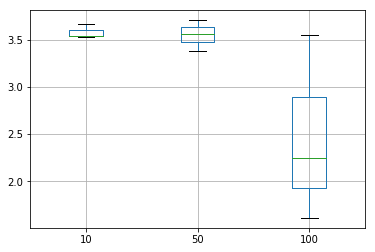

In [63]:
# experiments to tune epochs

results = pd.DataFrame()
batch_size = 4
n_neurons = 1

# vary training epochs
epochs = [10, 50, 100]

for e in epochs:
    results[str(e)] = experiment(batch_size, n_neurons, e)
    
# summarize results
print(results.describe())

# save boxplot
results.boxplot()
plt.savefig('boxplot_epochs.png')

### Tune batch-size

Batch size influences how often the weights of the network are updated.

Now we hold <b>n_epochs = 100</b>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 1)                 56        
_________________________________________________________________
dense_139 (Dense)            (None, 10)                20        
_________________________________________________________________
dense_140 (Dense)            (None, 1)                 11        
Total params: 87
Trainable params: 87
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 - 50s - loss: 6.6480 - val_loss: 12.0273
Epoch 2/100
 - 32s - loss: 5.8923 - val_loss: 10.7284
Epoch 3/100
 - 31s - loss: 5.0417 - val_loss: 9.2174
Epoch 4/100
 - 29s - loss: 4.1411 - val_loss: 7.8523
Epoch 5/100
 - 29s - loss: 3.7531 - val_loss: 6.9708
Epoch 6/100
 - 32s - loss: 3.5843 - val_loss: 6.1977
Epoch 7/100
 - 30s - loss: 3.5232 - val_loss: 5.9030
Epoch 8/100
 - 31s - loss: 3.5417 - v

 - 20s - loss: 3.5121 - val_loss: 5.5796
Epoch 27/100
 - 20s - loss: 3.5123 - val_loss: 5.4695
Epoch 28/100
 - 20s - loss: 3.4796 - val_loss: 5.5274
Epoch 29/100
 - 20s - loss: 3.4817 - val_loss: 5.5531
Epoch 30/100
 - 20s - loss: 3.6098 - val_loss: 5.5237
Epoch 31/100
 - 20s - loss: 3.7193 - val_loss: 5.4894
Epoch 32/100
 - 20s - loss: 3.4392 - val_loss: 5.4494
Epoch 33/100
 - 20s - loss: 3.5063 - val_loss: 5.4756
Epoch 34/100
 - 20s - loss: 3.4703 - val_loss: 5.2345
Epoch 35/100
 - 20s - loss: 3.5199 - val_loss: 5.2420
Epoch 36/100
 - 20s - loss: 3.5842 - val_loss: 5.3054
Epoch 37/100
 - 21s - loss: 3.5301 - val_loss: 5.4813
Epoch 38/100
 - 20s - loss: 3.4940 - val_loss: 5.4184
Epoch 39/100
 - 20s - loss: 3.4888 - val_loss: 5.2580
Epoch 40/100
 - 20s - loss: 3.4125 - val_loss: 5.2373
Epoch 41/100
 - 20s - loss: 3.5299 - val_loss: 5.2498
Epoch 42/100
 - 20s - loss: 3.4842 - val_loss: 5.4101
Epoch 43/100
 - 20s - loss: 3.4016 - val_loss: 5.6511
Epoch 44/100
 - 20s - loss: 3.4464 - val_

Epoch 65/100
 - 20s - loss: 3.4441 - val_loss: 5.7769
Epoch 66/100
 - 20s - loss: 3.6236 - val_loss: 5.6526
Epoch 67/100
 - 20s - loss: 3.5833 - val_loss: 5.4970
Epoch 68/100
 - 20s - loss: 3.5691 - val_loss: 5.5241
Epoch 69/100
 - 20s - loss: 3.5548 - val_loss: 5.5311
Epoch 70/100
 - 20s - loss: 3.6483 - val_loss: 5.4500
Epoch 71/100
 - 20s - loss: 3.5187 - val_loss: 5.3780
Epoch 72/100
 - 20s - loss: 3.5537 - val_loss: 5.5644
Epoch 73/100
 - 20s - loss: 3.5211 - val_loss: 5.3865
Epoch 74/100
 - 20s - loss: 3.5553 - val_loss: 5.3611
Epoch 75/100
 - 20s - loss: 3.5387 - val_loss: 5.5047
Epoch 76/100
 - 20s - loss: 3.4327 - val_loss: 5.5312
Epoch 77/100
 - 20s - loss: 3.5549 - val_loss: 5.5669
Epoch 78/100
 - 20s - loss: 3.6840 - val_loss: 5.6206
Epoch 79/100
 - 20s - loss: 3.5386 - val_loss: 5.3911
Epoch 80/100
 - 20s - loss: 3.6760 - val_loss: 5.5153
Epoch 81/100
 - 20s - loss: 3.5538 - val_loss: 5.4763
Epoch 82/100
 - 20s - loss: 3.5134 - val_loss: 5.4792
Epoch 83/100
 - 20s - loss: 

Epoch 1/100
 - 41s - loss: 6.7268 - val_loss: 11.9640
Epoch 2/100
 - 21s - loss: 5.5107 - val_loss: 10.2156
Epoch 3/100
 - 21s - loss: 4.6369 - val_loss: 8.6144
Epoch 4/100
 - 21s - loss: 3.7954 - val_loss: 7.3246
Epoch 5/100
 - 21s - loss: 3.6574 - val_loss: 6.4616
Epoch 6/100
 - 21s - loss: 3.7859 - val_loss: 5.6462
Epoch 7/100
 - 21s - loss: 3.7511 - val_loss: 5.7146
Epoch 8/100
 - 21s - loss: 3.5188 - val_loss: 5.6947
Epoch 9/100
 - 21s - loss: 3.5093 - val_loss: 5.6450
Epoch 10/100
 - 21s - loss: 3.5019 - val_loss: 5.4380
Epoch 11/100
 - 21s - loss: 3.4064 - val_loss: 5.3829
Epoch 12/100
 - 21s - loss: 3.4518 - val_loss: 5.4391
Epoch 13/100
 - 21s - loss: 3.5044 - val_loss: 5.4247
Epoch 14/100
 - 21s - loss: 3.3942 - val_loss: 5.6223
Epoch 15/100
 - 21s - loss: 3.6342 - val_loss: 5.5877
Epoch 16/100
 - 21s - loss: 3.4533 - val_loss: 5.4520
Epoch 17/100
 - 21s - loss: 3.3957 - val_loss: 5.4587
Epoch 18/100
 - 21s - loss: 3.4799 - val_loss: 5.5737
Epoch 19/100
 - 21s - loss: 3.3622 

Epoch 40/100
 - 22s - loss: 3.5999 - val_loss: 5.4690
Epoch 41/100
 - 22s - loss: 3.5501 - val_loss: 5.5459
Epoch 42/100
 - 22s - loss: 3.4537 - val_loss: 5.5179
Epoch 43/100
 - 22s - loss: 3.4745 - val_loss: 5.6921
Epoch 44/100
 - 22s - loss: 3.5017 - val_loss: 5.8299
Epoch 45/100
 - 22s - loss: 3.4483 - val_loss: 5.7212
Epoch 46/100
 - 22s - loss: 3.4293 - val_loss: 5.6774
Epoch 47/100
 - 22s - loss: 3.4466 - val_loss: 5.4270
Epoch 48/100
 - 22s - loss: 3.5787 - val_loss: 5.4272
Epoch 49/100
 - 22s - loss: 3.4641 - val_loss: 5.5487
Epoch 50/100
 - 22s - loss: 3.5241 - val_loss: 5.4147
Epoch 51/100
 - 22s - loss: 3.5875 - val_loss: 5.4726
Epoch 52/100
 - 22s - loss: 3.7074 - val_loss: 5.5330
Epoch 53/100
 - 22s - loss: 3.6058 - val_loss: 5.4317
Epoch 54/100
 - 22s - loss: 3.5755 - val_loss: 5.6409
Epoch 55/100
 - 22s - loss: 3.5101 - val_loss: 5.4092
Epoch 56/100
 - 22s - loss: 3.4804 - val_loss: 5.3154
Epoch 57/100
 - 22s - loss: 3.4304 - val_loss: 5.2970
Epoch 58/100
 - 22s - loss: 

Epoch 79/100
 - 21s - loss: 3.5480 - val_loss: 5.5142
Epoch 80/100
 - 20s - loss: 3.4446 - val_loss: 5.8028
Epoch 81/100
 - 21s - loss: 3.5993 - val_loss: 5.6084
Epoch 82/100
 - 20s - loss: 3.7284 - val_loss: 5.3493
Epoch 83/100
 - 20s - loss: 3.4460 - val_loss: 5.4796
Epoch 84/100
 - 20s - loss: 3.5371 - val_loss: 5.4359
Epoch 85/100
 - 20s - loss: 3.6176 - val_loss: 5.1260
Epoch 86/100
 - 20s - loss: 3.4305 - val_loss: 5.2426
Epoch 87/100
 - 20s - loss: 3.6165 - val_loss: 5.3601
Epoch 88/100
 - 20s - loss: 3.4563 - val_loss: 5.2506
Epoch 89/100
 - 20s - loss: 3.5708 - val_loss: 5.4138
Epoch 90/100
 - 20s - loss: 3.6249 - val_loss: 5.2015
Epoch 91/100
 - 20s - loss: 3.4901 - val_loss: 5.3106
Epoch 92/100
 - 20s - loss: 3.4796 - val_loss: 5.3287
Epoch 93/100
 - 20s - loss: 3.5213 - val_loss: 5.5460
Epoch 94/100
 - 20s - loss: 3.5805 - val_loss: 5.5837
Epoch 95/100
 - 20s - loss: 3.5080 - val_loss: 5.4010
Epoch 96/100
 - 20s - loss: 3.4338 - val_loss: 5.4049
Epoch 97/100
 - 20s - loss: 

 - 21s - loss: 4.5365 - val_loss: 8.2279
Epoch 5/100
 - 21s - loss: 3.8500 - val_loss: 7.4910
Epoch 6/100
 - 21s - loss: 3.8288 - val_loss: 6.7552
Epoch 7/100
 - 21s - loss: 3.5983 - val_loss: 6.2494
Epoch 8/100
 - 21s - loss: 3.5204 - val_loss: 5.9454
Epoch 9/100
 - 21s - loss: 3.5063 - val_loss: 5.6146
Epoch 10/100
 - 21s - loss: 3.5027 - val_loss: 5.5427
Epoch 11/100
 - 21s - loss: 3.4851 - val_loss: 5.3809
Epoch 12/100
 - 21s - loss: 3.6352 - val_loss: 5.4226
Epoch 13/100
 - 21s - loss: 3.5790 - val_loss: 5.3576
Epoch 14/100
 - 21s - loss: 3.5018 - val_loss: 5.6157
Epoch 15/100
 - 21s - loss: 3.4882 - val_loss: 5.3798
Epoch 16/100
 - 21s - loss: 3.6790 - val_loss: 5.3323
Epoch 17/100
 - 21s - loss: 3.6199 - val_loss: 5.4815
Epoch 18/100
 - 21s - loss: 3.6159 - val_loss: 5.7316
Epoch 19/100
 - 21s - loss: 3.4768 - val_loss: 5.8387
Epoch 20/100
 - 21s - loss: 3.4658 - val_loss: 5.7453
Epoch 21/100
 - 21s - loss: 3.4766 - val_loss: 5.4643
Epoch 22/100
 - 21s - loss: 3.3744 - val_loss:

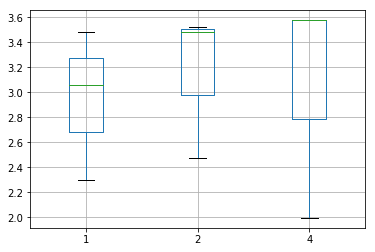

In [72]:
# experiments to tune batch_size

results = pd.DataFrame()
n_epochs = 100
n_neurons = 1

# vary training epochs
batch_size = [1, 2, 4]

for b in batch_size:
    results[str(b)] = experiment(b, n_neurons, n_epochs)
    
# summarize results
print(results.describe())

# save boxplot
results.boxplot()
plt.savefig('boxplot_batch_size.png')

### Tune the number of neurons

The number of neurons influences the complexity level of the network. It allows more accuracy and sometimes overfitting.
But it also increses the computational cost.

We keep <b>epochs = 100</b> and <b>batch_size = 1</b>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 2)                 120       
_________________________________________________________________
dense_157 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_158 (Dense)            (None, 1)                 11        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 - 44s - loss: 7.0001 - val_loss: 11.9285
Epoch 2/100
 - 21s - loss: 5.7191 - val_loss: 9.9434
Epoch 3/100
 - 23s - loss: 4.2749 - val_loss: 7.9265
Epoch 4/100
 - 22s - loss: 3.6506 - val_loss: 7.0920
Epoch 5/100
 - 21s - loss: 3.7393 - val_loss: 5.9838
Epoch 6/100
 - 21s - loss: 3.5893 - val_loss: 6.1305
Epoch 7/100
 - 21s - loss: 3.4774 - val_loss: 6.0620
Epoch 8/100
 - 21s - loss: 3.5028 - 

 - 21s - loss: 3.3341 - val_loss: 5.8656
Epoch 27/100
 - 21s - loss: 3.4124 - val_loss: 5.0814
Epoch 28/100
 - 21s - loss: 3.5282 - val_loss: 5.2675
Epoch 29/100
 - 21s - loss: 3.4222 - val_loss: 5.4265
Epoch 30/100
 - 21s - loss: 3.4800 - val_loss: 5.1523
Epoch 31/100
 - 21s - loss: 3.3542 - val_loss: 5.2451
Epoch 32/100
 - 21s - loss: 3.5510 - val_loss: 5.8395
Epoch 33/100
 - 21s - loss: 3.4140 - val_loss: 5.1229
Epoch 34/100
 - 21s - loss: 3.3292 - val_loss: 5.2366
Epoch 35/100
 - 21s - loss: 3.5102 - val_loss: 4.8885
Epoch 36/100
 - 21s - loss: 3.3834 - val_loss: 4.5986
Epoch 37/100
 - 21s - loss: 3.3687 - val_loss: 4.9685
Epoch 38/100
 - 21s - loss: 3.3973 - val_loss: 5.3485
Epoch 39/100
 - 21s - loss: 3.5406 - val_loss: 5.6922
Epoch 40/100
 - 21s - loss: 3.2882 - val_loss: 4.7155
Epoch 41/100
 - 21s - loss: 3.3455 - val_loss: 5.1248
Epoch 42/100
 - 21s - loss: 3.4615 - val_loss: 4.5179
Epoch 43/100
 - 21s - loss: 3.3737 - val_loss: 4.8936
Epoch 44/100
 - 21s - loss: 3.5327 - val_

Epoch 65/100
 - 22s - loss: 1.8780 - val_loss: 0.7966
Epoch 66/100
 - 22s - loss: 1.9255 - val_loss: 0.4257
Epoch 67/100
 - 22s - loss: 1.7667 - val_loss: 0.4171
Epoch 68/100
 - 22s - loss: 1.6991 - val_loss: 0.8941
Epoch 69/100
 - 23s - loss: 1.7342 - val_loss: 1.7868
Epoch 70/100
 - 22s - loss: 1.8156 - val_loss: 0.3308
Epoch 71/100
 - 22s - loss: 1.7607 - val_loss: 0.5762
Epoch 72/100
 - 22s - loss: 1.6905 - val_loss: 1.2836
Epoch 73/100
 - 22s - loss: 1.7299 - val_loss: 0.2379
Epoch 74/100
 - 22s - loss: 1.8342 - val_loss: 1.1048
Epoch 75/100
 - 23s - loss: 1.6410 - val_loss: 0.6578
Epoch 76/100
 - 22s - loss: 1.6448 - val_loss: 0.2766
Epoch 77/100
 - 23s - loss: 1.8380 - val_loss: 1.2720
Epoch 78/100
 - 22s - loss: 1.7225 - val_loss: 0.5541
Epoch 79/100
 - 22s - loss: 1.6606 - val_loss: 0.8937
Epoch 80/100
 - 23s - loss: 1.6669 - val_loss: 0.4228
Epoch 81/100
 - 23s - loss: 1.6346 - val_loss: 0.8904
Epoch 82/100
 - 22s - loss: 1.6513 - val_loss: 0.2624
Epoch 83/100
 - 23s - loss: 

Epoch 1/100
 - 46s - loss: 6.1766 - val_loss: 10.4449
Epoch 2/100
 - 22s - loss: 4.4634 - val_loss: 7.9182
Epoch 3/100
 - 22s - loss: 3.5700 - val_loss: 6.1346
Epoch 4/100
 - 22s - loss: 3.3535 - val_loss: 5.7969
Epoch 5/100
 - 22s - loss: 3.5406 - val_loss: 5.6460
Epoch 6/100
 - 22s - loss: 3.4323 - val_loss: 5.4081
Epoch 7/100
 - 22s - loss: 3.5738 - val_loss: 5.3160
Epoch 8/100
 - 22s - loss: 3.5489 - val_loss: 5.6878
Epoch 9/100
 - 22s - loss: 3.4632 - val_loss: 5.3080
Epoch 10/100
 - 22s - loss: 3.4924 - val_loss: 5.4992
Epoch 11/100
 - 22s - loss: 3.5855 - val_loss: 5.5342
Epoch 12/100
 - 22s - loss: 3.5268 - val_loss: 5.6338
Epoch 13/100
 - 22s - loss: 3.4309 - val_loss: 5.7002
Epoch 14/100
 - 22s - loss: 3.5809 - val_loss: 5.4564
Epoch 15/100
 - 22s - loss: 3.5311 - val_loss: 5.2550
Epoch 16/100
 - 22s - loss: 3.4109 - val_loss: 5.3872
Epoch 17/100
 - 22s - loss: 3.4352 - val_loss: 5.1014
Epoch 18/100
 - 22s - loss: 3.3999 - val_loss: 5.4409
Epoch 19/100
 - 22s - loss: 3.2435 -

Epoch 40/100
 - 22s - loss: 2.0852 - val_loss: 0.5309
Epoch 41/100
 - 22s - loss: 1.9945 - val_loss: 1.1797
Epoch 42/100
 - 22s - loss: 1.8188 - val_loss: 1.0063
Epoch 43/100
 - 22s - loss: 1.9473 - val_loss: 0.4821
Epoch 44/100
 - 22s - loss: 1.9083 - val_loss: 0.5506
Epoch 45/100
 - 22s - loss: 1.8373 - val_loss: 1.8277
Epoch 46/100
 - 22s - loss: 1.9305 - val_loss: 0.7669
Epoch 47/100
 - 22s - loss: 1.9565 - val_loss: 0.7708
Epoch 48/100
 - 22s - loss: 1.9101 - val_loss: 0.5157
Epoch 49/100
 - 22s - loss: 1.7045 - val_loss: 1.6172
Epoch 50/100
 - 22s - loss: 1.8226 - val_loss: 0.8479
Epoch 51/100
 - 22s - loss: 1.6978 - val_loss: 0.5699
Epoch 52/100
 - 22s - loss: 1.6997 - val_loss: 0.2472
Epoch 53/100
 - 23s - loss: 1.8285 - val_loss: 0.7913
Epoch 54/100
 - 22s - loss: 1.7889 - val_loss: 0.4069
Epoch 55/100
 - 22s - loss: 1.8154 - val_loss: 0.2867
Epoch 56/100
 - 22s - loss: 1.7452 - val_loss: 0.3625
Epoch 57/100
 - 22s - loss: 1.7137 - val_loss: 0.4794
Epoch 58/100
 - 22s - loss: 

Epoch 79/100
 - 24s - loss: 1.5379 - val_loss: 1.5714
Epoch 80/100
 - 23s - loss: 1.5170 - val_loss: 1.3451
Epoch 81/100
 - 23s - loss: 1.5399 - val_loss: 1.2584
Epoch 82/100
 - 23s - loss: 1.5923 - val_loss: 0.6847
Epoch 83/100
 - 23s - loss: 1.4960 - val_loss: 0.6174
Epoch 84/100
 - 23s - loss: 1.5373 - val_loss: 0.5583
Epoch 85/100
 - 23s - loss: 1.5076 - val_loss: 0.3558
Epoch 86/100
 - 29s - loss: 1.5691 - val_loss: 0.7021
Epoch 87/100
 - 32s - loss: 1.5469 - val_loss: 0.7587
Epoch 88/100
 - 26s - loss: 1.4336 - val_loss: 0.2317
Epoch 89/100
 - 29s - loss: 1.4046 - val_loss: 0.8797
Epoch 90/100
 - 32s - loss: 1.5023 - val_loss: 0.5444
Epoch 91/100
 - 29s - loss: 1.4769 - val_loss: 0.4158
Epoch 92/100
 - 33s - loss: 1.6163 - val_loss: 1.3373
Epoch 93/100
 - 28s - loss: 1.5437 - val_loss: 0.5858
Epoch 94/100
 - 32s - loss: 1.4696 - val_loss: 0.5492
Epoch 95/100
 - 28s - loss: 1.4414 - val_loss: 1.4090
Epoch 96/100
 - 28s - loss: 1.5668 - val_loss: 0.9620
Epoch 97/100
 - 28s - loss: 

 - 24s - loss: 3.6130 - val_loss: 5.4132
Epoch 5/100
 - 24s - loss: 3.4254 - val_loss: 5.3495
Epoch 6/100
 - 24s - loss: 3.4049 - val_loss: 5.7655
Epoch 7/100
 - 24s - loss: 3.0616 - val_loss: 3.3599
Epoch 8/100
 - 24s - loss: 2.5426 - val_loss: 2.4015
Epoch 9/100
 - 24s - loss: 2.4099 - val_loss: 1.1702
Epoch 10/100
 - 24s - loss: 2.5159 - val_loss: 1.8155
Epoch 11/100
 - 24s - loss: 2.4274 - val_loss: 2.0009
Epoch 12/100
 - 24s - loss: 2.0996 - val_loss: 2.2557
Epoch 13/100
 - 27s - loss: 2.0409 - val_loss: 1.3098
Epoch 14/100
 - 24s - loss: 2.1064 - val_loss: 1.7374
Epoch 15/100
 - 24s - loss: 1.9679 - val_loss: 3.8845
Epoch 16/100
 - 24s - loss: 2.7110 - val_loss: 2.1526
Epoch 17/100
 - 23s - loss: 2.2001 - val_loss: 1.0370
Epoch 18/100
 - 23s - loss: 2.0650 - val_loss: 0.9635
Epoch 19/100
 - 23s - loss: 2.2052 - val_loss: 0.7211
Epoch 20/100
 - 23s - loss: 1.9337 - val_loss: 1.3248
Epoch 21/100
 - 23s - loss: 1.9345 - val_loss: 1.2514
Epoch 22/100
 - 23s - loss: 2.0628 - val_loss:

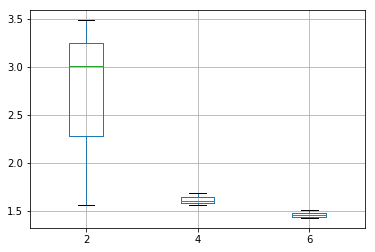

In [73]:
# experiments to tune batch_size

results = pd.DataFrame()
n_epochs = 100
batch_size = 1

# vary training epochs
n_neurons = [2, 4, 6]

for n in n_neurons:
    results[str(n)] = experiment(batch_size, n, n_epochs)
    
# summarize results
print(results.describe())

# save boxplot
results.boxplot()
plt.savefig('boxplot_neurons.png')

# Submission

In [14]:
import os
from tqdm import tqdm

# Load submission file
submission = pd.read_csv(r'C:\Users\alexi\Documents\LANL-Earthquake-Prediction\sample_submission.csv', 
                         index_col='seg_id', 
                         dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
 
    seg = pd.read_csv('Documents/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = model.predict(np.expand_dims(preprocess(x), 0))

submission.head()

# Save
submission.to_csv('submission_RNN_02.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 2624/2624 [03:55<00:00, 11.15it/s]
